# Column Detection V1

## Histogram Projection

columns detected: [(34, 537), (539, 549), (552, 576), (586, 599), (605, 627), (632, 645), (650, 658), (660, 1405), (1408, 1411), (1413, 1620)]


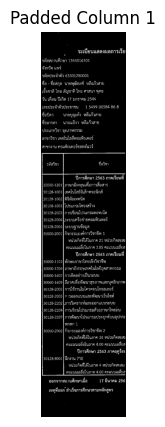

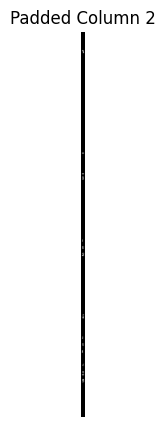

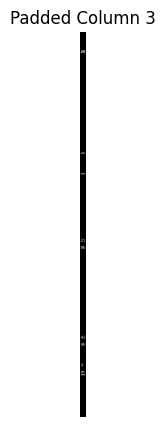

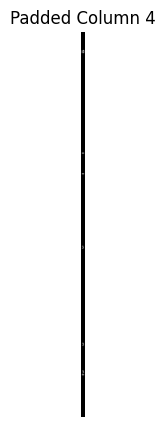

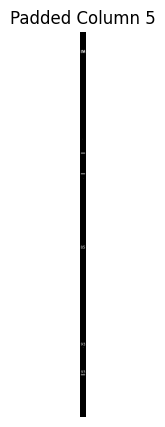

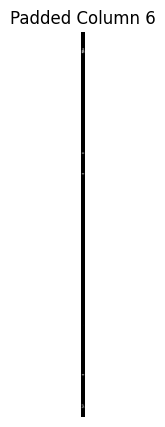

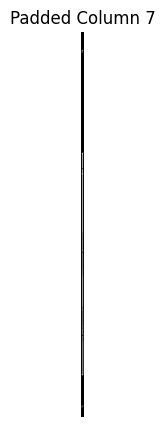

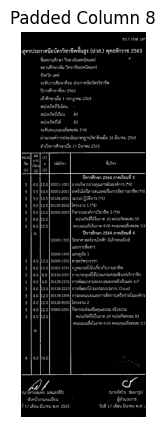

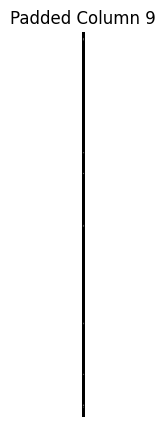

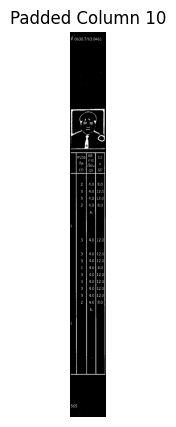

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_columns")
output_folder.mkdir(exist_ok=True)

#image = cv2.imread("../data/test_images/column_detection/a_A_0_1.jpg")
image = cv2.imread("../data/test_images/transcript/aun_20240817_0001.jpg")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

# คำนวณ Histogram Projection
horizontal_projection = np.sum(binary_image, axis=0)  # รวมพิกเซลในแนวนอน

threshold_value = 6000  # เพิ่มค่าให้เหมาะกับความหนาของตัวอักษร
column_indices = np.where(horizontal_projection > threshold_value)[0]

# แยกช่วงตำแหน่งแต่ละบรรทัด
columns = []
start_idx = None

for i in range(len(column_indices) - 1):
    if start_idx is None:
        start_idx = column_indices[i]
    if column_indices[i + 1] > column_indices[i] + 1:  # เจอช่องว่างระหว่างคอลัมน์
        end_idx = column_indices[i]
        columns.append((start_idx, end_idx))
        start_idx = None
if start_idx is not None:
    columns.append((start_idx, column_indices[-1]))

print("columns detected:", columns)

# แยกบรรทัดและเพิ่ม Padding
# ตัดภาพคอลัมน์แต่ละส่วน
column_images = [binary_image[:, start:end] for start, end in columns]

# กำหนดขนาด Padding (ในหน่วยพิกเซล)
padding_top = 0
padding_bottom = 0
padding_left = 5
padding_right = 5

# เพิ่ม Padding ให้แต่ละคอลัมน์
padded_column_images = []
for column_img in column_images:
    # เพิ่ม Padding ด้านบน, ด้านล่าง, ด้านซ้าย, ด้านขวา
    padded_img = np.pad(
        column_img,
        ((padding_top, padding_bottom), (padding_left, padding_right)),
        mode="constant",
        constant_values=0  # เติมด้วยสีดำ (0) สำหรับ Binary Image
    )
    padded_column_images.append(padded_img)

# แสดงผลภาพแต่ละคอลัมน์พร้อม Padding
for idx, padded_img in enumerate(padded_column_images):
    file_path = output_folder / f"col_{idx + 1}.png"
    cv2.imwrite(str(file_path), padded_img)
    plt.figure(figsize=(5, 5))
    plt.imshow(padded_img, cmap="gray")
    plt.title(f"Padded Column {idx + 1}")
    plt.axis("off")
    plt.show()